In [24]:
import os
import numpy as np
#Suppress Warning
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.layers import GRU, LSTM, Input, Dense
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [25]:
class Model_Custom:
    def __init__(self, num_features, time_steps, LSTM_units, GRU_units):     

        self.t = time_steps
        self.n = num_features

        inp =  Input(shape=(time_steps, num_features))

        LSTM_layer = LSTM(units=LSTM_units,return_sequences = True, return_state = True)

        Out_sequence, H, C = LSTM_layer(inp)

        GRU_layer = GRU(units = GRU_units)

        output_=GRU_layer(Out_sequence , initial_state=C)

        output = Dense(1)(output_)

        

        self.my_model =  Model(inp,output)
        optimi = Adam(learning_rate= 0.01)
        self.my_model.compile(optimizer=optimi, loss='mse', metrics=['mae', 'mse'])

    def summary(self):
        self.my_model.build((None, self.t, self.n))
        return self.my_model.summary()

    def fit(self, X, y, epochs=5, batch_size=16):
        callback = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)
        return self.my_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks = [callback])

    def predict(self, X):
        return self.my_model.predict(X)

In [26]:
df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    "Date",
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'treasury_10_year_rate',
    'breakeven_inflation_5_year_rate',
    'breakeven_inflation_10_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
]

target = 'cushing_crude_oil_price'

data = df[features + [target]]
#print(data)
data.set_index("Date", inplace= True)
data = data.resample('D').mean()
data = data.interpolate()

In [27]:
data

,dow_jones_adj_close_price,nasdaq_adj_close_price,sp_adj_close_price,usd_to_uk_exchange_rate,treasury_1_year_rate,treasury_10_year_rate,breakeven_inflation_5_year_rate,breakeven_inflation_10_year_rate,bank_prime_loan_rate,federal_funds_rate,cushing_crude_oil_price
Date,,,,,,,,,,,
2003-01-16,9.070833,7.261050,6.818487,1.607300,1.36,4.05,1.400000,1.790000,4.25,1.24,3.516310
2003-01-17,9.057974,7.227074,6.804371,1.617300,1.36,4.05,1.450000,1.800000,4.25,1.24,3.523710
2003-01-18,9.053751,7.224896,6.800414,1.616050,1.36,4.05,1.432500,1.795000,4.25,1.24,3.528818
2003-01-19,9.049528,7.222717,6.796457,1.614800,1.36,4.05,1.415000,1.790000,4.25,1.24,3.533926
2003-01-20,9.045304,7.220539,6.792500,1.613550,1.36,4.05,1.397500,1.785000,4.25,1.24,3.539034
...,...,...,...,...,...,...,...,...,...,...,...
2025-05-01,10.615284,9.781927,8.631261,1.327300,3.95,4.28,2.300000,2.250000,7.50,4.33,4.081597
2025-05-02,10.629040,9.796889,8.645880,1.328300,3.95,4.28,2.310000,2.270000,7.50,4.33,4.065431
2025-05-03,10.628243,9.794405,8.643746,1.328333,3.95,4.28,2.316667,2.273333,7.50,4.33,4.058730


In [28]:
def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])   # predict next day
    return np.array(X_seq), np.array(y_seq)

In [29]:
features.remove("Date")
scaler = MinMaxScaler()

data_scaler = scaler.fit_transform(data)

target_y = data_scaler[:, -1]
target_y

array([0.45333043, 0.45609654, 0.45800604, ..., 0.65609311, 0.65358842,
       0.65108374])

In [30]:
time_step = 5
X_seq, y_seq = create_sequences(data_scaler, target_y,time_step)

In [31]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [32]:
model = Model_Custom(
    num_features=X_train.shape[2],
    time_steps=time_step,
    LSTM_units=64,
    GRU_units=64
)

model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=10)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 5, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 5, 64),   │     19,456 │ input_layer_3[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 64)        │     24,960 │ lstm_3[0][0],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ gru_3[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,481 (173.75 KB)

 Trainable params: 44,481 (173.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0036 - mae: 0.0256 - mse: 0.0036
Epoch 2/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.3031e-04 - mae: 0.0174 - mse: 5.3031e-04
Epoch 3/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.2512e-04 - mae: 0.0135 - mse: 3.2512e-04
Epoch 4/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.9099e-04 - mae: 0.0128 - mse: 2.9099e-04
Epoch 5/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.4358e-04 - mae: 0.0116 - mse: 2.4358e-04
Epoch 6/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.3673e-04 - mae: 0.0115 - mse: 2.3673e-04
Epoch 7/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.2649e-04 - mae: 0.0115 - mse: 2.2649e-04
Epoch 8/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.3032e-04 - mae: 0.0115 - mse: 2.3032e-04
Epoch 9/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.4368e-04 - mae: 0.0119 - mse: 2.4368e-04
Epoch 10/50
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.8723e-04 - mae: 0.

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MSE: 0.014782840679853549


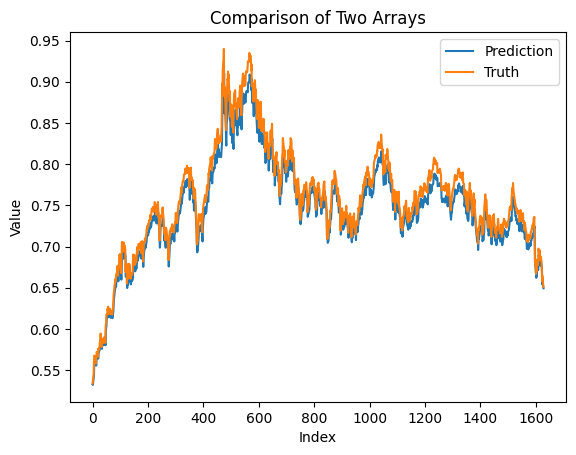

In [33]:
preds = model.predict(X_test)
print("MSE:", root_mean_squared_error(y_test, preds))

# Create index for x-axis
x = np.arange(len(preds))

plt.figure()

# Plot both arrays
plt.plot(x, preds, label="Prediction")
plt.plot(x, y_test, label="Truth")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()



204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE: 0.008970672300099073


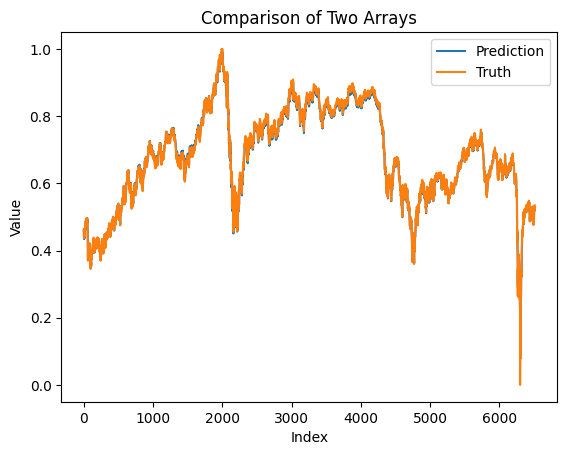

In [35]:
preds = model.predict(X_train)
print("MSE:", root_mean_squared_error(y_train, preds))

# Create index for x-axis
x = np.arange(len(preds))

plt.figure()

# Plot both arrays
plt.plot(x, preds, label="Prediction")
plt.plot(x, y_train, label="Truth")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()

